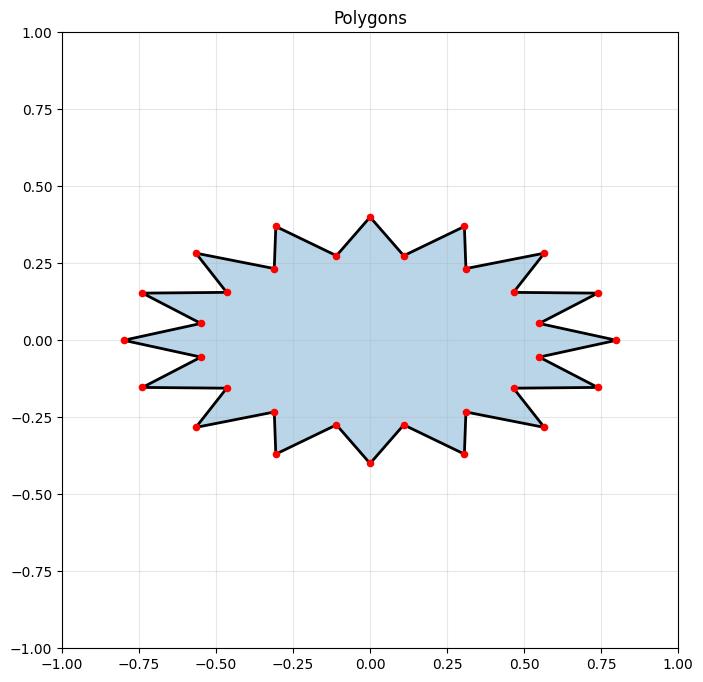

In [7]:
import torch
import torch.nn as nn
from typing import List
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import matplotlib


def plot_cell_sdf(
        net,
        resolution: int = 300,
        device = None,
        line_segments = None
    ):
    """
    Plot SDF heatmap with activation boundaries and line segments.
    
    Args:
        net: Neural network model
        resolution: Grid resolution for the heatmap
        device: Device to run computations on
        line_segments: Optional list of LineSegments objects to overlay on the plot
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if net.input_dim != 2 or net.output_dim != 1:
        print(f"Warning: plot_cell_sdf expects 2D input and 1D output, got input_dim={net.input_dim}, output_dim={net.output_dim}")
        return
    
    # Grid & network pass
    x = torch.linspace(-1, 1, resolution)
    y = torch.linspace(-1, 1, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

    with torch.no_grad():
        net = net.to(device)
        sdf_vals, preacts = net.eval_activations(grid_pts.to(device))

    L = net.num_layers
    H = net.hidden_dim

    sdf_grid = sdf_vals.view(resolution, resolution).cpu().numpy()
    preacts = preacts.view(resolution, resolution, L, H).cpu()

    fig, ax = plt.subplots(figsize=(10, 8))

    # SDF heat-map
    vmin, vmax = sdf_grid.min(), sdf_grid.max()
    if vmin >= 0:
        cmap = LinearSegmentedColormap.from_list('pos', ['#ffcccc','red','darkred'])
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    elif vmax <= 0:
        cmap = LinearSegmentedColormap.from_list('neg', ['darkblue','blue','#ccccff'])
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    else:
        cmap = LinearSegmentedColormap.from_list('cent', ['blue','white','red'])
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    im = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=500, cmap=cmap, norm=norm)

    # Activation boundaries
    colors = ['cyan','orange','magenta','yellow','lime','red','purple','brown'][:L]
    rgba = [plt.matplotlib.colors.to_rgba(c) for c in colors]

    for l in range(L):
        for h in range(H):
            ax.contour(xx.cpu(), yy.cpu(),
                    preacts[:, :, l, h], levels=[0],
                    linewidths=1.2,
                    colors=rgba[l],
                    alpha=0.9,
                    zorder=1)

    # Predicted boundary
    ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0], colors='black',
               linewidths=1.2, linestyles='--')
    
    # Draw line segments if provided
    if line_segments is not None:
        # Group segments by activation pattern (across all layers)
        patterns = {}
        for seg in line_segments:
            # Create pattern tuple from all layers
            pattern = tuple(
                tuple(seg.activations.get(layer, [])) 
                for layer in sorted(seg.activations.keys())
            )
            if pattern not in patterns:
                patterns[pattern] = []
            patterns[pattern].append(seg)
        
        for pattern_idx, (pattern, segs) in enumerate(patterns.items()):
            for seg_idx, seg in enumerate(segs):
                verts = seg.vertices
                
                if seg.closed:
                    plot_verts = np.vstack([verts, verts[0]])
                else:
                    plot_verts = verts
                
                # Plot with black color
                ax.plot(plot_verts[:, 0], plot_verts[:, 1], 
                    color='black', linewidth=2.5, alpha=0.9, 
                    linestyle='-', zorder=10)
                
                # Mark vertices
                ax.scatter(verts[:, 0], verts[:, 1], 
                        c='black', s=40, zorder=11, 
                        edgecolors='white', linewidths=1.5)
                
                # Add label with number of vertices
                midpoint = np.mean(verts, axis=0)
                ax.text(midpoint[0], midpoint[1], f'{len(verts)}v', 
                       fontsize=8, ha='center', va='center',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                alpha=0.7, edgecolor='black'),
                       zorder=12)
        
    # Add pattern info to title
    
    # Legend
    handles = [mpatches.Patch(color=colors[i], label=f'layer {i+1} boundary') for i in range(L)]
    ax.legend(handles=handles, loc='upper right', fontsize=8)

    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'SDF Heat-Map ({len(line_segments)} segments, {len(patterns)} patterns)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.3f'))
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('SDF value', fontsize=10)
    cbar.locator = matplotlib.ticker.MaxNLocator(nbins=7)
    cbar.update_ticks()

    plt.tight_layout()
    plt.show()

def generate_polygons(spec, convex=True, star_ratio=0.5, stretch=(1.0, 1.0)):
    """
    Generate non-overlapping polygons in [-1, 1]^2 based on a specification string.
    
    Parameters:
    -----------
    spec : str
        Specification string in format "n_polygons x vertices_per_polygon"
        Examples: "3x4" (3 polygons with 4 vertices each)
                  "4x5" (4 polygons with 5 vertices each)
        
        Alternatively, can specify different vertices per polygon:
        "4,3,5" (3 polygons with 4, 3, and 5 vertices respectively)
    
    convex : bool
        If True, generate convex polygons (regular polygons)
        If False, generate non-convex star-like polygons
    
    star_ratio : float (0 to 1)
        For non-convex polygons, ratio of inner radius to outer radius
        Smaller values create more pronounced star shapes
        Only used when convex=False
    
    stretch : tuple, list, or float
        Stretching factor for polygons in (x, y) directions.
        - Single float: uniform scaling (e.g., 1.5)
        - Tuple (sx, sy): stretch all polygons by sx in x and sy in y
        - List of tuples: per-polygon stretch factors
        Examples: (2.0, 1.0) stretches 2x in x-direction (rectangles from squares)
                  (1.0, 0.5) compresses in y-direction (flattened shapes)
    
    Returns:
    --------
    list of np.ndarray
        List of polygon vertex arrays, each of shape (n_vertices+1, 2)
        The last vertex is repeated to close the polygon
    """
    # Parse the specification
    if 'x' in spec:
        # Format: "n_polygons x vertices_per_polygon"
        parts = spec.split('x')
        n_polygons = int(parts[0])
        vertices_per_polygon = int(parts[1])
        vertices_list = [vertices_per_polygon] * n_polygons
    else:
        # Format: "v1,v2,v3,..."
        vertices_list = [int(v) for v in spec.split(',')]
        n_polygons = len(vertices_list)
    
    # Parse stretch parameter
    if isinstance(stretch, (int, float)):
        # Single float: uniform scaling
        stretch_list = [(stretch, stretch)] * n_polygons
    elif isinstance(stretch, tuple):
        # Tuple: same stretch for all polygons
        stretch_list = [stretch] * n_polygons
    elif isinstance(stretch, list):
        # List: per-polygon stretches
        stretch_list = stretch
        if len(stretch_list) < n_polygons:
            # Extend with (1.0, 1.0) if not enough specified
            stretch_list.extend([(1.0, 1.0)] * (n_polygons - len(stretch_list)))
    else:
        stretch_list = [(1.0, 1.0)] * n_polygons
    
    # Determine grid layout to fit polygons without overlap
    grid_cols = int(np.ceil(np.sqrt(n_polygons)))
    grid_rows = int(np.ceil(n_polygons / grid_cols))
    
    # Cell dimensions (with padding)
    padding = 0.05
    cell_width = 2.0 / grid_cols
    cell_height = 2.0 / grid_rows
    
    polygons = []
    
    for idx, n_vertices in enumerate(vertices_list):
        # Determine cell position
        row = idx // grid_cols
        col = idx % grid_cols
        
        # Cell center in [-1, 1]^2
        cell_center_x = -1.0 + cell_width * (col + 0.5)
        cell_center_y = -1.0 + cell_height * (row + 0.5)
        
        # Get stretch factors for this polygon
        sx, sy = stretch_list[idx]
        
        # Polygon radius (inscribed in cell with padding, accounting for stretch)
        # Ensure stretched polygon fits within cell boundaries
        radius_x = (cell_width / 2) * 0.8 / sx if sx > 0 else cell_width * 0.4
        radius_y = (cell_height / 2) * 0.8 / sy if sy > 0 else cell_height * 0.4
        radius = min(radius_x, radius_y)
        
        if convex:
            # Generate regular convex polygon vertices
            angles = np.linspace(0, 2 * np.pi, n_vertices, endpoint=False)
            angles += idx * 0.3
            
            vertices = np.zeros((n_vertices, 2))
            vertices[:, 0] = cell_center_x + radius * sx * np.cos(angles)
            vertices[:, 1] = cell_center_y + radius * sy * np.sin(angles)
        else:
            # Generate non-convex star-like polygon
            n_points = n_vertices * 2
            angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
            angles += idx * 0.3
            
            # Alternate between outer and inner radii
            radii = np.zeros(n_points)
            radii[::2] = radius
            radii[1::2] = radius * star_ratio
            
            vertices = np.zeros((n_points, 2))
            vertices[:, 0] = cell_center_x + radii * sx * np.cos(angles)
            vertices[:, 1] = cell_center_y + radii * sy * np.sin(angles)
        
        polygons.append(vertices)
    
    return polygons

    

def plot_polygons(polygons, figsize=(8, 8), title="Polygons"):
    """Plot polygons (assumes closed polygons without duplicated last vertex)"""
    plt.figure(figsize=figsize)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))
    
    for i, polygon in enumerate(polygons):
        # Close polygon by adding first vertex at end
        closed_poly = np.vstack([polygon, polygon[0]])
        plt.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2)
        plt.fill(closed_poly[:, 0], closed_poly[:, 1], color=colors[i], alpha=0.3)
        
        # Mark all vertices
        plt.scatter(polygon[:, 0], polygon[:, 1], c='red', s=20, zorder=5)
    
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


polygons = generate_polygons('1x16', convex=False, star_ratio=0.7, stretch=(1.0, 0.5))
plot_polygons(polygons)

In [8]:
class LineSegments:
    def __init__(self, vertices: np.ndarray, normals: np.ndarray, offsets: np.ndarray, 
                 closed=True, activations=None):
        self.vertices = vertices
        self.closed = closed
        self.normals = normals
        self.offsets = offsets
        # activations is now a dict: {layer_idx: [activation_values]}
        self.activations = activations if activations is not None else {}
    
    def split(self, n, d, layer, eps=1e-8):
        """
        Split by hyperplane n·x + d = 0 and record activation in specified layer.
        
        Args:
            n: normal vector
            d: offset
            layer: which layer this split belongs to (0, 1, 2, ...)
            eps: tolerance for zero
        """
        SD = self.vertices @ n + d
        
        SD_min = SD.min()
        SD_max = SD.max()

        if SD_min>-eps:
            # Case 1.1: No split - all vertices are positive
            activation = 1
            new_activations = self.activations.copy()
            if layer not in new_activations:
                new_activations[layer] = []
            new_activations[layer] = new_activations[layer] + [activation]
            return [LineSegments(self.vertices.copy(), self.normals.copy(), 
                                 self.offsets.copy(), self.closed, 
                                 new_activations)]
        elif SD_max<eps:
            # Case 1.2: No split - all vertices are negative
            activation = 0
            new_activations = self.activations.copy()
            if layer not in new_activations:
                new_activations[layer] = []
            new_activations[layer] = new_activations[layer] + [activation]
            return [LineSegments(self.vertices.copy(), self.normals.copy(), 
                                 self.offsets.copy(), self.closed, 
                                 new_activations)]

        
        V  = self.vertices
        N = self.normals
        O = self.offsets
        ON = np.abs(SD) <= eps
        S  = np.sign(SD).astype(np.int8)
        S[ON] = 0

        n_verts = len(V)
        
        current_V = []
        current_N = []
        current_O = []
        segments = []

        for i in range(0, n_verts):
            if ON[i]:
                current_V.append(V[i])
                current_N.append(N[i])
                current_O.append(O[i])
                new_activations = self.activations.copy()
                if layer not in new_activations:
                    new_activations[layer] = []
                new_activations[layer] = new_activations[layer] + [0 if S[i-1]==-1 else 1]
                segment = LineSegments(
                    np.array(current_V),
                    np.array(current_N),
                    np.array(current_O),
                    False,
                    new_activations
                )
                segments.append(segment)
                current_V = [V[i]]
                current_N = [N[i]]
                current_O = [O[i]]
                continue
            elif (self.closed or i>0) and S[i]*S[i-1]==-1:
                denom = SD[i]-SD[i-1]
                t = -SD[i-1]/denom
                P = V[i-1]+t*(V[i]-V[i-1])
                current_V.append(P)
                current_N.append(N[i-1])
                current_O.append(O[i-1])

                new_activations = self.activations.copy()
                if layer not in new_activations:
                    new_activations[layer] = []
                new_activations[layer] = new_activations[layer] + [0 if S[i-1]==-1 else 1]
                segment = LineSegments(
                    np.array(current_V),
                    np.array(current_N),
                    np.array(current_O),
                    False,
                    new_activations
                )
                segments.append(segment)

                current_V = [P, V[i]]
                current_N = [N[i], N[i]]
                current_O = [O[i], O[i]]
                continue

            current_V.append(V[i])
            current_N.append(N[i])
            current_O.append(O[i])
        
        if self.closed:
            segments[0].vertices = np.concatenate([np.array(current_V), segments[0].vertices])
            segments[0].normals = np.concatenate([np.array(current_N), segments[0].normals])
            segments[0].offsets = np.concatenate([np.array(current_O), segments[0].offsets])
        elif len(current_V)>1:
            new_activations = self.activations.copy()
            if layer not in new_activations:
                new_activations[layer] = []
            new_activations[layer] = new_activations[layer] + [0 if S[-1]==-1 else 1]
            segment = LineSegments(
                np.array(current_V),
                np.array(current_N),
                np.array(current_O),
                False,
                new_activations
            )
            segments.append(segment)

        return segments

    def double_split(self, n, d, layer, eps=1e-8):
        """
        Split by both n·x + d > 0 AND its complement -n·x + (-d) > 0.
        This creates two neurons that partition space complementarily.
        Returns segments with activations for both neurons appended.
        
        Args:
            n: normal vector
            d: offset
            layer: which layer this split belongs to (0, 1, 2, ...)
            eps: tolerance
        """
        # First split: n·x + d > 0
        segments_first = self.split(n, d, layer, eps)
    
        # Second split: each segment from first split by -n·x + (-d) > 0
        final_segments = []
        for seg in segments_first:
            # Split by the complement (which is equivalent to n·x + d < 0 on the other side)
            segments_second = seg.split(-n, -d, layer, eps)
            final_segments.extend(segments_second)
    
        return final_segments

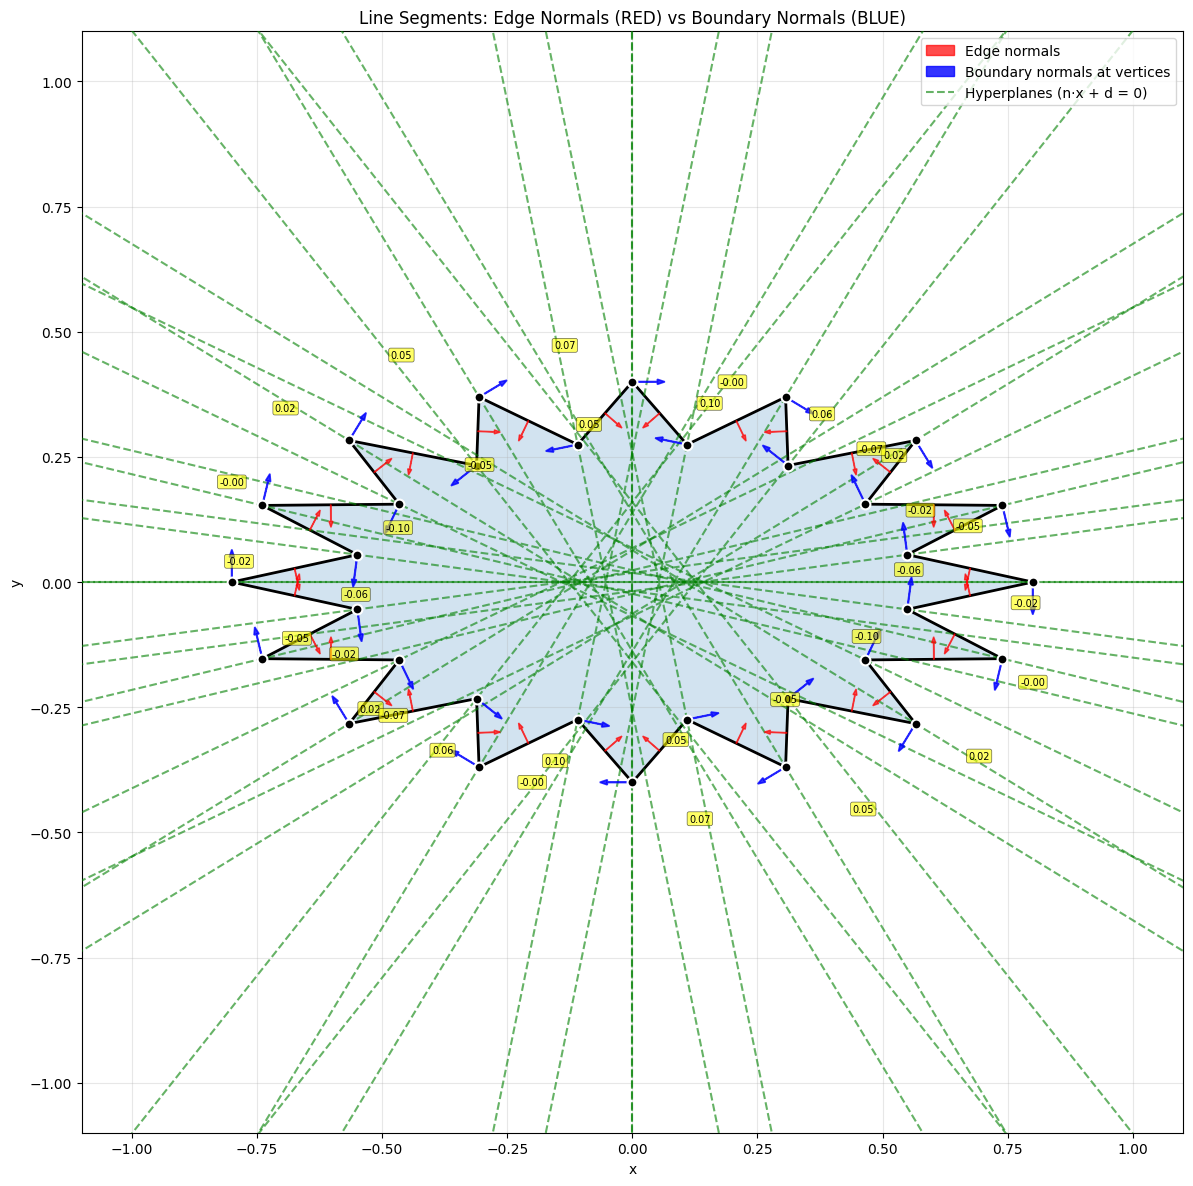

In [9]:
line_segments = []
for vertices in polygons:
    n_verts = len(vertices)
    closed = True
    
    # Vectorized computation
    # Get previous and next vertices for all vertices at once
    vertices_prev = np.roll(vertices, 1, axis=0)  # Shift down by 1
    vertices_next = np.roll(vertices, -1, axis=0)  # Shift up by 1
    
    # Compute edge vectors
    edges_before = vertices - vertices_prev  # Points TO current vertex
    edges_after = vertices_next - vertices   # Points FROM current vertex
    
    # Normalize edge directions
    edges_before_norm = edges_before / (np.linalg.norm(edges_before, axis=1, keepdims=True) + 1e-8)
    edges_after_norm = edges_after / (np.linalg.norm(edges_after, axis=1, keepdims=True) + 1e-8)
    
    # FLIP edges_before since it points backwards (into the vertex)
    # We want both to point "forward" along the polygon boundary
    edges_before_norm = -edges_before_norm
    
    # Average the edge directions to get the tangent bisector
    tangent_bisector = (edges_before_norm + edges_after_norm) / 2
    tangent_bisector = tangent_bisector / (np.linalg.norm(tangent_bisector, axis=1, keepdims=True) + 1e-8)
    
    # Rotate tangent bisector 90° CCW to get the boundary normal (perpendicular to bisector)
    boundary_normals = np.stack([-tangent_bisector[:, 1], tangent_bisector[:, 0]], axis=1)
    
    # Compute offsets
    offsets = -np.sum(boundary_normals * vertices, axis=1)
    
    line_segment = LineSegments(vertices, boundary_normals, offsets, closed)
    line_segments.append(line_segment)

# Visualize normals and offsets
fig, ax = plt.subplots(figsize=(12, 12))

colors = plt.cm.tab10(np.linspace(0, 1, len(polygons)))

for poly_idx, (polygon, seg) in enumerate(zip(polygons, line_segments)):
    color = colors[poly_idx]
    
    # Draw the polygon
    closed_poly = np.vstack([polygon, polygon[0]])
    ax.plot(closed_poly[:, 0], closed_poly[:, 1], 'k-', linewidth=2)
    ax.fill(closed_poly[:, 0], closed_poly[:, 1], color=color, alpha=0.2)
    
    n_verts = len(polygon)
    
    # Draw edge normals (red arrows on edge midpoints)
    for i in range(n_verts):
        v_curr = polygon[i]
        v_next = polygon[(i + 1) % n_verts]
        
        # Edge midpoint
        edge_mid = (v_curr + v_next) / 2
        
        # Edge vector and its normal
        edge = v_next - v_curr
        edge_normal = np.array([-edge[1], edge[0]])
        edge_normal = edge_normal / (np.linalg.norm(edge_normal) + 1e-8)
        
        # Draw edge normal (RED) - smaller and pointier
        arrow_scale = 0.033  # 1/3 of 0.1
        ax.arrow(edge_mid[0], edge_mid[1], 
                edge_normal[0] * arrow_scale, edge_normal[1] * arrow_scale,
                head_width=0.008, head_length=0.012, fc='red', ec='red', 
                alpha=0.7, linewidth=1.0, zorder=5)
    
    # Draw boundary normals at vertices (BLUE arrows)
    for i in range(n_verts):
        vertex = seg.vertices[i]
        boundary_normal = seg.normals[i]
        offset = seg.offsets[i]
        
        # Draw the hyperplane: boundary_normal · x + offset = 0
        # This is a line perpendicular to boundary_normal
        # Tangent direction (perpendicular to normal)
        tangent = np.array([boundary_normal[1], -boundary_normal[0]])
        
        # Extend dashed line to plot boundaries
        # Find intersections with plot boundaries (-1.1 to 1.1)
        line_length = 3.0  # Large enough to span the plot
        p1 = vertex - tangent * line_length
        p2 = vertex + tangent * line_length
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
               'g--', linewidth=1.5, alpha=0.6, zorder=4)
        
        # Draw boundary normal (BLUE) - smaller and pointier
        arrow_scale = 0.05  # 1/3 of 0.15
        ax.arrow(vertex[0], vertex[1], 
                boundary_normal[0] * arrow_scale, boundary_normal[1] * arrow_scale,
                head_width=0.01, head_length=0.015, fc='blue', ec='blue', 
                alpha=0.8, linewidth=1.2, zorder=6)
        
        # Draw vertex point
        ax.scatter(vertex[0], vertex[1], c='black', s=50, zorder=7, 
                  edgecolors='white', linewidths=1.5)
        
        # Add offset label
        label_offset = boundary_normal * 0.2
        ax.text(vertex[0] + label_offset[0], vertex[1] + label_offset[1], 
               f'{offset:.2f}',
               fontsize=7, ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', 
                        alpha=0.6, edgecolor='black', linewidth=0.5),
               zorder=8)

# Add legend
from matplotlib.patches import FancyArrow
from matplotlib.lines import Line2D
red_arrow = FancyArrow(0, 0, 0.1, 0, width=0.02, color='red', alpha=0.7)
blue_arrow = FancyArrow(0, 0, 0.1, 0, width=0.02, color='blue', alpha=0.8)
green_line = Line2D([0], [0], color='green', linestyle='--', linewidth=1.5, alpha=0.6)
ax.legend([red_arrow, blue_arrow, green_line], 
         ['Edge normals', 'Boundary normals at vertices', 'Hyperplanes (n·x + d = 0)'],
         loc='upper right', fontsize=10)

ax.set_aspect('equal')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Line Segments: Edge Normals (RED) vs Boundary Normals (BLUE)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
import copy

class ReluMLP(nn.Module):
    
    def __init__(self, input_dim=2, hidden_dim=3, num_layers=3, output_dim=1):
        """ReLU MLP with skip connections from input to each layer."""
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        # Hidden layers - each takes (hidden_dim + input_dim) due to skip connections
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim + input_dim, hidden_dim)
            for _ in range(num_layers - 1)
        ])
        
        # Output layer - also receives skip connection from input
        self.output_layer = nn.Linear(hidden_dim + input_dim, output_dim)
    
    def forward(self, x):
        # Store original input for skip connections
        x_input = x
        
        # Input layer + ReLU
        x = torch.relu(self.input_layer(x))
        
        # Hidden layers with skip connections
        for hidden_layer in self.hidden_layers:
            x = torch.cat([x, x_input], dim=-1)
            x = torch.relu(hidden_layer(x))
        
        # Output layer with skip connection (no ReLU)
        x = torch.cat([x, x_input], dim=-1)
        x = self.output_layer(x)
        
        return x
    
    def eval_activations(self, x):
        # Store original input for skip connections
        x_input = x
        preacts = []
        
        # Input layer
        x = self.input_layer(x)
        preacts.append(x.clone())
        x = torch.relu(x)
        
        # Hidden layers with skip connections
        for hidden_layer in self.hidden_layers:
            x = torch.cat([x, x_input], dim=-1)
            x = hidden_layer(x)
            preacts.append(x.clone())
            x = torch.relu(x)
        
        # Output layer with skip connection (no ReLU, no preact recording)
        x = torch.cat([x, x_input], dim=-1)
        x = self.output_layer(x)
        
        return x, torch.stack(preacts, dim=1)

model = ReluMLP(2, 8, 1)
# plot_cell_sdf(model, line_segments=line_segments)


In [11]:
def get_split(line_segments):
    segment_count = [
        len(seg.vertices) if seg.closed else len(seg.vertices)-2
        for seg in line_segments
    ]
    seg_idx = np.argmax(segment_count)
    seg = line_segments[seg_idx]
    vert_idx = len(seg.vertices)//2
    return seg.normals[vert_idx], seg.offsets[vert_idx]

current_line_segments: List[LineSegments] = copy.deepcopy(line_segments)
new_line_segments: List[LineSegments] = []

model.layers[0].weight.data = torch.zeros_like(model.layers[0].weight.data)
model.layers[0].bias.data = torch.zeros_like(model.layers[0].bias.data)
model.layers[0].bias.data[:] = -1.0

normals = []
weights = []
for i in range(model.hidden_dim//2):
    normal, offset = get_split(current_line_segments)
    for line_segment in current_line_segments:
        new_line_segments.extend(line_segment.double_split(normal, offset, layer=0))

    # Set weights for neuron i (positive direction)
    model.layers[0].weight.data[2*i, :] = torch.tensor(normal, dtype=torch.float32)
    model.layers[0].bias.data[2*i] = torch.tensor(offset, dtype=torch.float32)
    
    # Set weights for neuron i+1 (negative direction - complement)
    model.layers[0].weight.data[2*i + 1, :] = torch.tensor(-normal, dtype=torch.float32)
    model.layers[0].bias.data[2*i + 1] = torch.tensor(-offset, dtype=torch.float32)


    # plot_cell_sdf(model, line_segments=new_line_segments)
    current_line_segments = new_line_segments
    new_line_segments = []
    normals.append(normal)
    weights.append(offset)

plot_cell_sdf(model, line_segments=current_line_segments)

AttributeError: 'ReluMLP' object has no attribute 'layers'

In [ ]:
W0 = model.input_layer.weight.data.detach().cpu().numpy()
b0 = model.input_layer.bias.data.detach().cpu().numpy()

print("Verifying activation patterns:")
for idx, seg in enumerate(current_line_segments):  # Check first 5
    if seg.closed or len(seg.vertices) < 2:
        continue
    
    if len(seg.vertices) == 2:
        V0, V1 = seg.vertices[0], seg.vertices[-1]
        midpoint = (V0 + V1) / 2
    else:
        midpoint = seg.vertices[len(seg.vertices)//2]
    print(midpoint)
    
    # Compute actual activations at midpoint for layer 0
    z_mid = W0 @ midpoint + b0
    actual_act = (z_mid > 0).astype(int)
    stored_act = np.array(seg.activations.get(0, []), dtype=int)
    
    print(f"Segment {idx}:")
    print(f"  Layer 0 Stored:  {stored_act}")
    print(f"  Layer 0 Actual:  {actual_act}")
    print(f"  Match: {np.array_equal(stored_act, actual_act)}")
    
    if not np.array_equal(stored_act, actual_act):
        print(f"  MISMATCH! Differences at indices: {np.where(stored_act != actual_act)[0]}")

Verifying activation patterns:
[-0.73910363 -0.15307337]
Segment 0:
  Layer 0 Stored:  [0 1 1 0 1 0 1 0]
  Layer 0 Actual:  [0 1 1 0 1 0 1 0]
  Match: True
[-0.30614675 -0.36955181]
Segment 1:
  Layer 0 Stored:  [0 1 1 0 0 1 1 0]
  Layer 0 Actual:  [0 1 1 0 0 1 1 0]
  Match: True
[ 0.30614675 -0.36955181]
Segment 2:
  Layer 0 Stored:  [0 1 0 1 0 1 1 0]
  Layer 0 Actual:  [0 1 0 1 0 1 1 0]
  Match: True
[ 0.73910363 -0.15307337]
Segment 3:
  Layer 0 Stored:  [0 1 0 1 0 1 0 1]
  Layer 0 Actual:  [0 1 0 1 0 1 0 1]
  Match: True
[0.46562298 0.15555967]
Segment 4:
  Layer 0 Stored:  [1 0 0 1 0 1 0 1]
  Layer 0 Actual:  [1 0 0 1 0 1 0 1]
  Match: True
[0.10925058 0.27461988]
Segment 5:
  Layer 0 Stored:  [1 0 0 1 1 0 0 1]
  Layer 0 Actual:  [1 0 0 1 1 0 0 1]
  Match: True
[-0.30614675  0.36955181]
Segment 6:
  Layer 0 Stored:  [1 0 1 0 1 0 0 1]
  Layer 0 Actual:  [1 0 1 0 1 0 0 1]
  Match: True
[-0.46562298  0.15555967]
Segment 7:
  Layer 0 Stored:  [1 0 1 0 1 0 1 0]
  Layer 0 Actual:  [1 0 

Rank: 7/11, Residuals: []
SDF at boundary: 0.001441 (should be ~0)


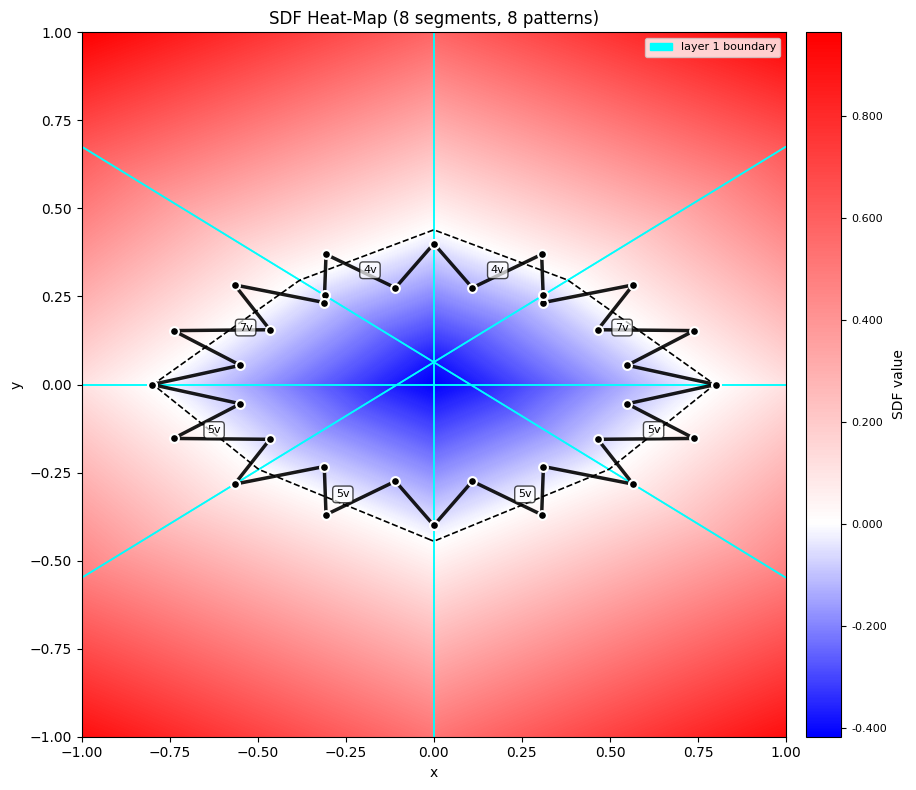

In [ ]:
num_hidden = model.hidden_dim
input_dim = model.input_dim
A_rows = []
y_targets = []

for seg in current_line_segments:
    # --- Calculate Target Geometry (RHS of equation) ---
    V0, V1 = seg.vertices[0], seg.vertices[-1]
    edge = V1 - V0
    
    # Normal vector (-dy, dx)
    normal = np.array([-edge[1], edge[0]])
    norm_len = np.linalg.norm(normal)
    
    assert norm_len > 1e-9

    # Negate to flip SDF: negative inside, positive outside
    # Original SDF: n·x - n·V0, New SDF: -n·x + n·V0
    unit_normal = normal / norm_len
    target_n = -unit_normal              # Flip the gradient direction
    target_c = np.dot(V0, unit_normal)   # Offset for the flipped SDF

    # --- Build Matrix Rows (LHS of equation) ---
    # seg.activations[0] is a list of which layer 0 neurons are ON
    mask = np.array(seg.activations.get(0, []), dtype=bool)
    
    # With skip connections, output receives [hidden_output, x]
    # So: f(x) = w_hidden @ relu(input_layer(x)) + w_skip @ x + b
    # Gradient: w_hidden @ diag(mask) @ W0 + w_skip
    # Offset: w_hidden @ diag(mask) @ b0 + b
    
    # Equation 1: Match X-Slope
    # (w_hidden[mask] @ W0[mask, 0]) + w_skip[0] = target_n[0]
    row_x = np.zeros(num_hidden + input_dim + 1)
    row_x[:num_hidden][mask] = W0[mask, 0]
    row_x[num_hidden] = 1.0  # Coefficient for w_skip[0]
    # (final bias coeff is 0 for slope equations)
    A_rows.append(row_x)
    y_targets.append(target_n[0])

    # Equation 2: Match Y-Slope
    # (w_hidden[mask] @ W0[mask, 1]) + w_skip[1] = target_n[1]
    row_y = np.zeros(num_hidden + input_dim + 1)
    row_y[:num_hidden][mask] = W0[mask, 1]
    row_y[num_hidden + 1] = 1.0  # Coefficient for w_skip[1]
    A_rows.append(row_y)
    y_targets.append(target_n[1])

    # Equation 3: Match Offset
    # (w_hidden[mask] @ b0[mask]) + b_out = target_c
    row_c = np.zeros(num_hidden + input_dim + 1)
    row_c[:num_hidden][mask] = b0[mask]
    row_c[num_hidden + input_dim] = 1.0  # Coefficient for the final bias
    A_rows.append(row_c)
    y_targets.append(target_c)

# 2. Solve System
A = np.array(A_rows)
y = np.array(y_targets)

# np.linalg.lstsq finds the best fit.
# If underdetermined -> Returns minimum norm solution (perfect regularizer)
# If overdetermined -> Returns least squares approximation
solution, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)

# 3. Assign Weights
w_hidden_data = solution[:num_hidden]
w_skip_data = solution[num_hidden:num_hidden + input_dim]
b_out_data = solution[num_hidden + input_dim]

# Combine hidden and skip weights into output layer
w_out_data = np.concatenate([w_hidden_data, w_skip_data])

# Assuming model.output_layer is your output Linear(hidden + input_dim, 1)
device = model.input_layer.weight.device

with torch.no_grad():
    model.output_layer.weight.data = torch.tensor(w_out_data.reshape(1, -1), dtype=torch.float32, device=device)
    model.output_layer.bias.data = torch.tensor([b_out_data], dtype=torch.float32, device=device)

print(f"Rank: {rank}/{len(solution)}, Residuals: {residuals}")

# Test on first segment
seg = current_line_segments[0]
test_point = seg.vertices[0]
with torch.no_grad():
    sdf_val = model(torch.from_numpy(test_point).unsqueeze(0).float().to(device))
    print(f"SDF at boundary: {sdf_val.item():.6f} (should be ~0)")

# solve it analytically with least squares
plot_cell_sdf(model, line_segments=current_line_segments)

Layer 1: Attempting to add hidden layer neurons...
  Neuron pair 0: Successfully added to hidden layer
    Created 18 segments after splitting
  Neuron pair 1: Successfully added to hidden layer
    Created 22 segments after splitting
  Neuron pair 2: Successfully added to hidden layer
    Created 24 segments after splitting
  Neuron pair 3: Successfully added to hidden layer
    Created 28 segments after splitting
  Neuron pair 4: Successfully added to hidden layer
    Created 30 segments after splitting
  Neuron pair 5: Successfully added to hidden layer
    Created 32 segments after splitting
  Neuron pair 6: Successfully added to hidden layer
    Created 34 segments after splitting
  Neuron pair 7: Successfully added to hidden layer
    Created 36 segments after splitting
Layer 1 complete. Total segments: 36
Rank: 3/19
Hard constraint error: 0.000113
Soft constraint error: 0.359767

Testing SDF at vertices (should be ~0):
Segment 0: V0=-0.001632, V1=-0.000985
Segment 1: V0=-0.00098

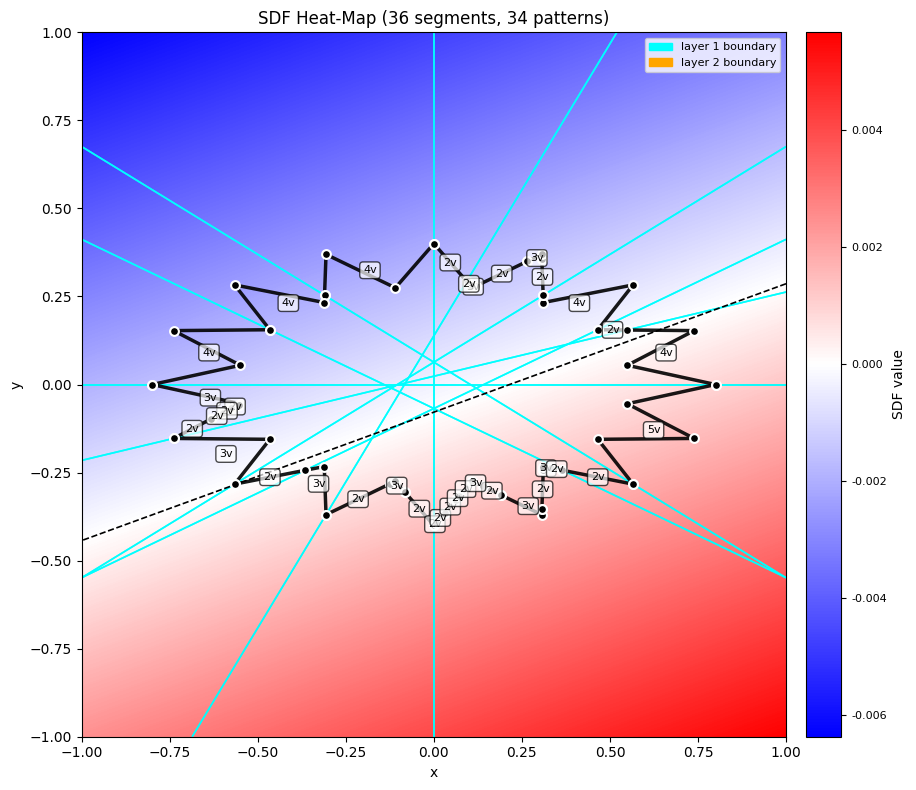

In [12]:
# Multi-layer version with relaxed constraints
import numpy as np
import torch
import copy
from typing import List

torch.manual_seed(0)
model = ReluMLP(2, 16, 2)

def get_split(line_segments):
    segment_count = [
        len(seg.vertices) if seg.closed else len(seg.vertices)-2
        for seg in line_segments
    ]
    seg_idx = np.argmax(segment_count)
    seg = line_segments[seg_idx]
    vert_idx = len(seg.vertices)//2
    return seg.normals[vert_idx], seg.offsets[vert_idx]

# Initialize
current_line_segments: List[LineSegments] = copy.deepcopy(line_segments)
new_line_segments: List[LineSegments] = []

model.input_layer.weight.data = torch.zeros_like(model.input_layer.weight.data)
model.input_layer.bias.data = torch.zeros_like(model.input_layer.bias.data)
model.input_layer.bias.data[:] = 0.0

model.hidden_layers[0].weight.data = torch.zeros_like(model.hidden_layers[0].weight.data)
model.hidden_layers[0].bias.data = torch.zeros_like(model.hidden_layers[0].bias.data)
model.hidden_layers[0].bias.data[:] = 0.0

# Layer 0: Create hyperplane splits
normals = []
weights = []
for i in range(model.hidden_dim//2):
    normal, offset = get_split(current_line_segments)
    for line_segment in current_line_segments:
        new_line_segments.extend(line_segment.double_split(normal, offset, layer=0))

    model.input_layer.weight.data[2*i, :] = torch.tensor(normal, dtype=torch.float32)
    model.input_layer.bias.data[2*i] = torch.tensor(offset, dtype=torch.float32)
    
    model.input_layer.weight.data[2*i + 1, :] = torch.tensor(-normal, dtype=torch.float32)
    model.input_layer.bias.data[2*i + 1] = torch.tensor(-offset, dtype=torch.float32)

    current_line_segments = new_line_segments
    new_line_segments = []
    normals.append(normal)
    weights.append(offset)

# Layer 1: Solve with relaxed constraints
W0 = model.input_layer.weight.data.detach().cpu().numpy()
b0 = model.input_layer.bias.data.detach().cpu().numpy()
input_dim = model.input_dim
soft_weight = 0.1  # Weight for normal direction constraints

print("Layer 1: Attempting to add hidden layer neurons...")
for i in range(model.hidden_dim//2):
    segment_count = np.array([
        len(seg.vertices) if seg.closed else len(seg.vertices)-2
        for seg in current_line_segments
    ])

    if not segment_count.any():
        print("No segments left")
        break

    seg_indices = np.argsort(segment_count)[::-1]
    seg_indices = seg_indices[segment_count[seg_indices] >= 1]
    
    A_hard = np.empty((0, model.hidden_dim + input_dim + 1))
    y_hard = np.empty(0)
    A_soft = np.empty((0, model.hidden_dim + input_dim + 1))
    y_soft = np.empty(0)
    solution = None
    
    for seg_idx in seg_indices:
        seg = current_line_segments[seg_idx]
        normal = seg.normals[len(seg.vertices)//2]
        offset = seg.offsets[len(seg.vertices)//2]
        mask = np.array(seg.activations.get(0, []), dtype=float)
        
        V0, V1 = seg.vertices[0], seg.vertices[-1]
        
        # Hard constraints: hyperplane passes through vertices
        row_v0 = np.zeros(model.hidden_dim + input_dim + 1)
        row_v0[:model.hidden_dim] = mask * (W0 @ V0 + b0)
        row_v0[model.hidden_dim:model.hidden_dim+input_dim] = V0
        row_v0[model.hidden_dim + input_dim] = 1.0
        
        row_v1 = np.zeros(model.hidden_dim + input_dim + 1)
        row_v1[:model.hidden_dim] = mask * (W0 @ V1 + b0)
        row_v1[model.hidden_dim:model.hidden_dim+input_dim] = V1
        row_v1[model.hidden_dim + input_dim] = 1.0
        
        # Soft constraints: gradient alignment
        row_x = np.zeros(model.hidden_dim + input_dim + 1)
        row_x[:model.hidden_dim] = W0[:, 0] * mask
        row_x[model.hidden_dim] = 1.0
        
        row_y = np.zeros(model.hidden_dim + input_dim + 1)
        row_y[:model.hidden_dim] = W0[:, 1] * mask
        row_y[model.hidden_dim + 1] = 1.0
        
        # Try adding these constraints
        A_hard_new = np.vstack([row_v0, row_v1])
        y_hard_new = np.array([0.0, 0.0])
        A_soft_new = np.vstack([row_x, row_y])
        y_soft_new = np.array([normal[0], normal[1]])
        
        A_hard_candidate = np.vstack([A_hard, A_hard_new]) if A_hard.shape[0] > 0 else A_hard_new
        y_hard_candidate = np.hstack([y_hard, y_hard_new]) if y_hard.shape[0] > 0 else y_hard_new
        A_soft_candidate = np.vstack([A_soft, A_soft_new]) if A_soft.shape[0] > 0 else A_soft_new
        y_soft_candidate = np.hstack([y_soft, y_soft_new]) if y_soft.shape[0] > 0 else y_soft_new
        
        # Check consistency of hard constraints
        A_augmented = np.column_stack([A_hard_candidate, y_hard_candidate])
        rank_A = np.linalg.matrix_rank(A_hard_candidate, tol=1e-10)
        rank_aug = np.linalg.matrix_rank(A_augmented, tol=1e-10)
        
        if rank_A != rank_aug:
            continue
        
        # Combine hard and weighted soft constraints
        A_combined = np.vstack([A_hard_candidate, A_soft_candidate * soft_weight])
        y_combined = np.hstack([y_hard_candidate, y_soft_candidate * soft_weight])
        
        solution, residuals, rank, s = np.linalg.lstsq(A_combined, y_combined, rcond=None)
        
        # Verify hard constraints are satisfied
        hard_verification = A_hard_candidate @ solution
        hard_error = np.max(np.abs(hard_verification - y_hard_candidate))
        
        if hard_error > 1e-6:
            continue
        
        # Accept this solution
        A_hard = A_hard_candidate
        y_hard = y_hard_candidate
        A_soft = A_soft_candidate
        y_soft = y_soft_candidate
        
        w_hidden_data = solution[:model.hidden_dim]
        w_skip_data = solution[model.hidden_dim:model.hidden_dim + input_dim]
        b_out_data = solution[model.hidden_dim + input_dim]
        
        w_out_data = np.concatenate([w_hidden_data, w_skip_data])

        model.hidden_layers[0].weight.data[2*i, :] = torch.tensor(w_out_data, dtype=torch.float32)
        model.hidden_layers[0].bias.data[2*i] = torch.tensor(b_out_data, dtype=torch.float32)
        model.hidden_layers[0].weight.data[2*i + 1, :] = torch.tensor(-w_out_data, dtype=torch.float32)
        model.hidden_layers[0].bias.data[2*i + 1] = torch.tensor(-b_out_data, dtype=torch.float32)

    if solution is not None:
        print(f"  Neuron pair {i}: Successfully added to hidden layer")
        
        # Extract weights from the solution
        w_hidden_data = solution[:model.hidden_dim]
        w_skip_data = solution[model.hidden_dim:model.hidden_dim + input_dim]
        b_out_data = solution[model.hidden_dim + input_dim]
        
        new_segments = []
        
        for seg in current_line_segments:
            # Get activation pattern from layer 0
            seg_mask_raw = seg.activations.get(0, [])
            num_layer0_neurons = len(seg_mask_raw)
            
            if num_layer0_neurons > 0:
                seg_mask = np.array(seg_mask_raw, dtype=float)
                
                # Only use weights/matrices for neurons that exist
                w_hidden_active = w_hidden_data[:num_layer0_neurons]
                W0_active = W0[:num_layer0_neurons, :]  # 2D slice
                b0_active = b0[:num_layer0_neurons]
                
                effective_normal = (w_hidden_active * seg_mask) @ W0_active + w_skip_data
                effective_offset = (w_hidden_active * seg_mask) @ b0_active + b_out_data
            else:
                # No layer 0 activations, use only skip connection
                effective_normal = w_skip_data
                effective_offset = b_out_data
            
            norm = np.linalg.norm(effective_normal)
            if norm > 1e-8:
                effective_normal = effective_normal / norm
                effective_offset = effective_offset / norm
            
            new_segments.extend(seg.double_split(effective_normal, effective_offset, layer=1))
        
        current_line_segments = new_segments
        print(f"    Created {len(new_segments)} segments after splitting")
    else:
        print(f"  Neuron pair {i}: No valid solution found - skipping")

print(f"Layer 1 complete. Total segments: {len(current_line_segments)}")

# Final output layer with relaxed constraints
W0 = model.input_layer.weight.data.detach().cpu().numpy()
b0 = model.input_layer.bias.data.detach().cpu().numpy()
W1 = model.hidden_layers[0].weight.data.detach().cpu().numpy()
b1 = model.hidden_layers[0].bias.data.detach().cpu().numpy()

W1_hidden = W1[:, :model.hidden_dim]
W1_skip = W1[:, model.hidden_dim:]

num_hidden = model.hidden_dim
A_hard = []
y_hard = []
A_soft = []
y_soft = []

for seg in current_line_segments:
    V0, V1 = seg.vertices[0], seg.vertices[-1]
    edge = V1 - V0
    
    normal = np.array([-edge[1], edge[0]])
    norm_len = np.linalg.norm(normal)
    
    if norm_len < 1e-9:
        continue
    
    unit_normal = normal / norm_len
    target_n = -unit_normal

    mask0 = np.array(seg.activations.get(0, []), dtype=bool)
    mask1_raw = seg.activations.get(1, [])
    
    mask1 = np.zeros(num_hidden, dtype=bool)
    if len(mask1_raw) > 0:
        mask1[:len(mask1_raw)] = mask1_raw
    
    # Hard constraints: SDF = 0 at vertices
    row_v0 = np.zeros(num_hidden + input_dim + 1)
    for j in range(num_hidden):
        if mask1[j]:
            row_v0[j] = W1_hidden[j, mask0] @ (W0[mask0] @ V0 + b0[mask0]) + W1_skip[j] @ V0 + b1[j]
    row_v0[num_hidden:num_hidden+input_dim] = V0
    row_v0[num_hidden + input_dim] = 1.0
    A_hard.append(row_v0)
    y_hard.append(0.0)
    
    row_v1 = np.zeros(num_hidden + input_dim + 1)
    for j in range(num_hidden):
        if mask1[j]:
            row_v1[j] = W1_hidden[j, mask0] @ (W0[mask0] @ V1 + b0[mask0]) + W1_skip[j] @ V1 + b1[j]
    row_v1[num_hidden:num_hidden+input_dim] = V1
    row_v1[num_hidden + input_dim] = 1.0
    A_hard.append(row_v1)
    y_hard.append(0.0)
    
    # Soft constraints: gradient alignment
    row_x = np.zeros(num_hidden + input_dim + 1)
    for j in range(num_hidden):
        if mask1[j]:
            row_x[j] = W1_hidden[j, mask0] @ W0[mask0, 0] + W1_skip[j, 0]
    row_x[num_hidden] = 1.0
    A_soft.append(row_x)
    y_soft.append(target_n[0])

    row_y = np.zeros(num_hidden + input_dim + 1)
    for j in range(num_hidden):
        if mask1[j]:
            row_y[j] = W1_hidden[j, mask0] @ W0[mask0, 1] + W1_skip[j, 1]
    row_y[num_hidden + 1] = 1.0
    A_soft.append(row_y)
    y_soft.append(target_n[1])

soft_weight = 0.1

A_hard = np.array(A_hard)
y_hard = np.array(y_hard)
A_soft = np.array(A_soft) * soft_weight
y_soft = np.array(y_soft) * soft_weight

A_combined = np.vstack([A_hard, A_soft])
y_combined = np.hstack([y_hard, y_soft])

solution, residuals, rank, s = np.linalg.lstsq(A_combined, y_combined, rcond=None)

w_out_hidden_data = solution[:num_hidden]
w_out_skip_data = solution[num_hidden:num_hidden + input_dim]
b_out_data = solution[num_hidden + input_dim]

w_out_data = np.concatenate([w_out_hidden_data, w_out_skip_data])

device = model.input_layer.weight.device

with torch.no_grad():
    model.output_layer.weight.data = torch.tensor(w_out_data.reshape(1, -1), dtype=torch.float32, device=device)
    model.output_layer.bias.data = torch.tensor([b_out_data], dtype=torch.float32, device=device)

print(f"Rank: {rank}/{len(solution)}")
print(f"Hard constraint error: {np.sum((A_hard @ solution - y_hard)**2):.6f}")
print(f"Soft constraint error: {np.sum((A_soft @ solution - y_soft)**2):.6f}")

# Test SDF values at vertices
print("\nTesting SDF at vertices (should be ~0):")
max_error = 0.0
for i, seg in enumerate(current_line_segments[:10]):
    V0, V1 = seg.vertices[0], seg.vertices[-1]
    with torch.no_grad():
        sdf_v0 = model(torch.from_numpy(V0).unsqueeze(0).float().to(device)).item()
        sdf_v1 = model(torch.from_numpy(V1).unsqueeze(0).float().to(device)).item()
    max_error = max(max_error, abs(sdf_v0), abs(sdf_v1))
    if i < 5:
        print(f"Segment {i}: V0={sdf_v0:.6f}, V1={sdf_v1:.6f}")

print(f"\nMax SDF error at vertices: {max_error:.6f}")

plot_cell_sdf(model, line_segments=current_line_segments)